# Next Big Sound - Predicting iTunes Sales From Online Media Metrics

* Analysis performed by: Ajay Anand
* Website1: http://www.github.com/skyballin
* Website2: http://www.smokingsection.net

## The purpose of this analysis is to create a model using only online media metrics curated each day over a few years by Next Big Sound to predict iTunes sales. 

## The data set has 103 possible predictors and 909,457 total rows for the 1500+ unique artists.

## It contains sensitive sales information so I was asked to code unique identifiers for the artists. This kind of sucks because it would be fun to show who some of these artists are, although I can say that these artists capture artists across many genres, ages in music, and size! 

## Understanding the Data 

#### ArtistId: Unique artist identifier

#### Date: YYYY-MM-DD date corresponding to Day

#### *_t: Total values. e.g. Facebook_PageLikes_t is the total number of Facebook fans the artist has on that given day, typically measured around 6am MST.

#### *_d: Delta values. e.g. Facebook_PageLikes_d is the change in the total number of Facebook likes the artist page has on that given day (difference between today and yesterday)

#### IsReleaseDay: 1 if an album is being released (in the US) on this day, null otherwise.

#### iTunes_TrackUnits_Net__d: The net sales for that day from iTunes single track sales

## Something I like a lot about analyzing social media data for this analysis is that social media takes care of worrying about major events in an artists career. If there is a big event, you do not have to think twice about the fact that there will be a significant increase in social media. In this way, it is almost like social media indirectly captures those types of significant events, which were previously pretty difficult to pinpoint. 

In [1]:
import pandas as pd # Pandas to analyze data using DataFrames
import numpy as np # Numpy to perform mathematical operations on the data

import matplotlib.pyplot as plt # Matplotlib to assist in plotting the data
import seaborn as sns # Seaborn to assist in plotting the data
from seaborn import plt, color_palette

import statsmodels.formula.api as smf 
import scipy.stats as stats

from datetime import datetime # Datetime data type conversion
from datetime import date, time

from sklearn.cluster import KMeans

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression # Logistic Regression Modeling
from sklearn.linear_model import LinearRegression # Linear Regression Modeling
from sklearn.cross_validation import train_test_split # Train/Split
from sklearn.cross_validation import cross_val_score # Cross validation scoring of model
from sklearn.linear_model import lasso_path, enet_path
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

In [2]:
%matplotlib inline

### Step 1a: Data Preprocessing - Skip to Step 2 if already done

In [5]:
data = pd.read_csv('data/challenge_data.csv', index_col = 'Unnamed: 0')

In [6]:
data.head()

,ArtistId,Day,Date,Facebook_PageLikes_d,Facebook_PageLikes_t,Facebook_TalkingAboutThis_7day__d,Instagram_Comments_d,Instagram_Comments_t,Instagram_Followers_d,Instagram_Followers_t,...,YouTube_Thumbs_t,YouTube_VideoFavorites_d,YouTube_VideoFavorites_t,YouTube_VideoRaters_d,YouTube_VideoRaters_t,YouTube_VideoViews_d,YouTube_VideoViews_t,iTunes_AlbumUnits_Net__d,iTunes_TrackUnits_Net__d,IsReleaseDay
123,59,14975,2011-01-01,156,132465,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,490,NaN
124,59,14976,2011-01-02,179,132621,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,610,NaN
125,59,14977,2011-01-03,171,132800,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,476,NaN
126,59,14978,2011-01-04,183,132971,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,488,NaN
127,59,14979,2011-01-05,172,133154,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,385,NaN


In [8]:
data.shape

(909457, 103)

### Rather than dealing with actual dates, I have decided to break the variable of date down to "DayOfWeek" and "Month"
- DayOfWeek is a relevant factor based on previous knowledge of release information
- Month would indicate the season, which has a lot to do with cycles of sales in music

In [7]:
data.IsReleaseDay.fillna(0, inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].map(lambda dt: dt.dayofweek)
data['Month'] = data['Date'].map(lambda dt: dt.month)

##### Dealing with Missing Values

- Missing values from IsReleaseDay are simply 0's (0 = No, 1 = Yes)
- Missing values from social media metrics can be attributed to data not pulling from the social media site correctly
    - These values cannot be replaced with 0's
    - These values must be replaced with the mean value of the particular metric for the specific artist

In [106]:
meanmap = data.groupby('ArtistId').mean()
meanmap.fillna(0, inplace = True)

In [9]:
meanmap.head()

,Day,Facebook_PageLikes_d,Facebook_PageLikes_t,Facebook_TalkingAboutThis_7day__d,Instagram_Comments_d,Instagram_Comments_t,Instagram_Followers_d,Instagram_Followers_t,Instagram_Friends_Following__d,Instagram_Friends_Following__t,...,YouTube_VideoFavorites_t,YouTube_VideoRaters_d,YouTube_VideoRaters_t,YouTube_VideoViews_d,YouTube_VideoViews_t,iTunes_AlbumUnits_Net__d,iTunes_TrackUnits_Net__d,IsReleaseDay,DayOfWeek,Month
ArtistId,,,,,,,,,,,,,,,,,,,,,
59,15294.5,81.125806,168453.386328,1348.630573,0.000000,0.0,0.000000,0.000000,0,0,...,35389.247059,7.094241,21394.143590,0.000000,0.000000,16.058176,177.671900,0.001563,3.003125,5.881250
61,15294.5,127.342020,313771.039936,2561.945687,0.000000,0.0,0.000000,0.000000,0,0,...,2269.211009,2.272727,3553.851351,0.000000,0.000000,8.568075,32.296238,0.001563,3.003125,5.881250
73,15406.0,79.025000,117257.029630,1277.411576,0.000000,0.0,0.000000,0.000000,0,0,...,11048.528205,46.792079,18096.049505,4202.881188,1169030.846535,0.000000,0.000000,0.002433,2.987835,6.744526
77,15294.5,1219.318627,1029353.406400,14787.523962,0.000000,0.0,0.000000,0.000000,0,0,...,2483.604317,43.167883,4963.095541,5378.361702,599685.774038,41.839874,6543.795918,0.003125,3.003125,5.881250
81,15370.0,1816.272921,2194302.445607,28742.926752,28.558824,6207.4,144.147059,34867.342857,0,9,...,1967.500000,33.468927,5502.753425,1546.787546,192671.450161,132.778689,608.237219,0.002045,3.004090,6.766871


In [11]:
unique_artists = np.unique(data['ArtistId'].values)
cols = ['Facebook_PageLikes_d', 'Facebook_PageLikes_t', 'Facebook_TalkingAboutThis_7day__d', 'Instagram_Comments_d', 
        'Instagram_Comments_t', 'Instagram_Followers_d', 'Instagram_Followers_t', 'Instagram_Friends_Following__d', 
        'Instagram_Friends_Following__t', 'Instagram_Likes_d', 'Instagram_Likes_t', 'Instagram_Photos_d', 'Instagram_Photos_t', 
        'Lastfm_Listeners_d', 'Lastfm_Listeners_t', 'Lastfm_Plays_d', 'Lastfm_Plays_t', 'Lastfm_Shouts_d', 'Lastfm_Shouts_t', 
        'MediabaseFeed_RadioSpins_d', 'MySpace_Friends_d', 'MySpace_Friends_t', 'MySpace_Plays_d', 'MySpace_Plays_t', 
        'MySpace_ProfileViews_d', 'MySpace_ProfileViews_t', 'Pandora_Fans_d', 'Pandora_Fans_t', 'Purevolume_Comments_d', 
        'Purevolume_Comments_t', 'Purevolume_Fans_Favorites__d', 'Purevolume_Fans_Favorites__t', 'Purevolume_Plays_d', 
        'Purevolume_Plays_t', 'RadioWave_InternetRadioImpressions_d', 'RadioWave_InternetRadioSpins_d', 'RadioWave_PandoraImpressions_d', 
        'RadioWave_PandoraSpins_d', 'RadioWave_RhapsodyImpressions_d', 'RadioWave_RhapsodySpins_d', 'RadioWave_SiriusImpressions_d', 
        'RadioWave_SiriusSpins_d', 'RadioWave_SlackerImpressions_d', 'RadioWave_SlackerSpins_d', 'Rdio_Collections_d', 
        'Rdio_Collections_t', 'Rdio_Comments_d', 'Rdio_Comments_t', 'Rdio_Playlists_d', 'Rdio_Playlists_t', 'Rdio_Plays_d', 
        'Rdio_Plays_t', 'Rdio_TrackListeners_d', 'Rdio_TrackListeners_t', 'ReverbNation_Fans_d', 'ReverbNation_Fans_t', 
        'ReverbNation_Plays_d', 'ReverbNation_Plays_t', 'ReverbNation_RemoteImpressions_d', 'ReverbNation_RemoteImpressions_t', 
        'SoundCloud_Comments_d', 'SoundCloud_Comments_t', 'SoundCloud_Downloads_d', 'SoundCloud_Downloads_t', 'SoundCloud_Followers_d', 
        'SoundCloud_Followers_t', 'SoundCloud_Plays_d', 'SoundCloud_Plays_t', 'Twitter_Followers_d', 'Twitter_Followers_t', 
        'Twitter_Friends_Following__d', 'Twitter_Friends_Following__t', 'Twitter_Lists_d', 'Twitter_Lists_t', 'Twitter_Tweets_d', 
        'Twitter_Tweets_t', u'Vevo_VideoViews_d', u'Vevo_VideoViews_t', u'Vimeo_Comments_d', u'Vimeo_Comments_t', u'Vimeo_Plays_d', 
        u'Vimeo_Plays_t', u'Vimeo_VideoLikes_d', u'Vimeo_VideoLikes_t', u'Wikipedia_Pageviews_d', u'YouTube_ChannelViews_d', 
        u'YouTube_ChannelViews_t', u'YouTube_Subscribers_d', u'YouTube_Subscribers_t', u'YouTube_Thumbs_d', 
        u'YouTube_Thumbs_t', u'YouTube_VideoFavorites_d', u'YouTube_VideoFavorites_t', u'YouTube_VideoRaters_d', 
        u'YouTube_VideoRaters_t', u'YouTube_VideoViews_d', u'YouTube_VideoViews_t']

## Warning: This step takes a long time, you are essentially looking up on every single piece of data and filling in the mean from the specific artist metric column if the value is NaN (There are approximately 180,000 iterations of this loop!!!

In [13]:
def impute_means(data, unique_artists):
    for artist in unique_artists:
        for column in cols:
            data.loc[(data['ArtistId'] == artist) & (data[column].isnull()), column] = meanmap.ix[artist, column]

In [14]:
impute_means(data, unique_artists)

In [24]:
data.to_csv('data/challenge_clean.csv', index_col=False)

###Step 1b: Adding growth metrics

###Time Series Data v Count Data
- For this study, I have decided to attempt to use delta value counts and a growth percentage to see how that performs for a model

In [3]:
data_clean = pd.read_csv('data/challenge_clean.csv')
data_clean.iTunes_AlbumUnits_Net__d.fillna(0, inplace = True)
data_clean.iTunes_TrackUnits_Net__d.fillna(0, inplace = True)

In [4]:
tot_cols = ['Facebook_PageLikes_t', 'Instagram_Comments_t', 'Instagram_Followers_t', 'Instagram_Friends_Following__t', 
            'Instagram_Likes_t', 'Instagram_Photos_t', 'Lastfm_Listeners_t', 'Lastfm_Plays_t', 'Lastfm_Shouts_t', 
            'MySpace_Friends_t', 'MySpace_Plays_t', 'MySpace_ProfileViews_t', 'Pandora_Fans_t', 'Purevolume_Comments_t', 
            'Purevolume_Fans_Favorites__t', 'Purevolume_Plays_t', 'Rdio_Collections_t', 'Rdio_Comments_t', 'Rdio_Playlists_t',
            'Rdio_Plays_t', 'Rdio_TrackListeners_t', 'ReverbNation_Fans_t', 'ReverbNation_Plays_t', 
            'ReverbNation_RemoteImpressions_t', 'SoundCloud_Comments_t', 'SoundCloud_Downloads_t', 'SoundCloud_Followers_t', 
            'SoundCloud_Plays_t', 'Twitter_Followers_t', 'Twitter_Friends_Following__t', 'Twitter_Lists_t', 'Twitter_Tweets_t', 
            'Vevo_VideoViews_t', 'Vimeo_Comments_t', 'Vimeo_Plays_t', 'Vimeo_VideoLikes_t', 'YouTube_ChannelViews_t', 
            'YouTube_Subscribers_t', u'YouTube_Thumbs_d', 'YouTube_Thumbs_t', 'YouTube_VideoFavorites_t', 
            'YouTube_VideoRaters_t', 'YouTube_VideoViews_t']

In [5]:
delta_cols = ['Facebook_PageLikes_d', 'Facebook_TalkingAboutThis_7day__d', 'Instagram_Comments_d', 'Instagram_Followers_d', 
              'Instagram_Friends_Following__d', 'Instagram_Likes_d', 'Instagram_Photos_d', 'Lastfm_Listeners_d', 
              'Lastfm_Plays_d', 'Lastfm_Shouts_d', 'MediabaseFeed_RadioSpins_d', 'MySpace_Friends_d', 'MySpace_Plays_d', 
              'MySpace_ProfileViews_d', 'Pandora_Fans_d', 'Purevolume_Comments_d', 'Purevolume_Fans_Favorites__d', 
              'Purevolume_Plays_d', 'RadioWave_InternetRadioImpressions_d', 'RadioWave_InternetRadioSpins_d', 
              'RadioWave_PandoraImpressions_d', 'RadioWave_PandoraSpins_d', 'RadioWave_RhapsodyImpressions_d', 
              'RadioWave_RhapsodySpins_d', 'RadioWave_SiriusImpressions_d', 'RadioWave_SiriusSpins_d', 
              'RadioWave_SlackerImpressions_d', 'RadioWave_SlackerSpins_d', 'Rdio_Collections_d', 'Rdio_Comments_d', 
              'Rdio_Playlists_d', 'Rdio_Plays_d', 'Rdio_TrackListeners_d', 'ReverbNation_Fans_d', 'ReverbNation_Plays_d', 
              'ReverbNation_RemoteImpressions_d', 'SoundCloud_Comments_d', 'SoundCloud_Downloads_d', 'SoundCloud_Followers_d', 
              'SoundCloud_Plays_d', 'Twitter_Followers_d', 'Twitter_Friends_Following__d', 'Twitter_Lists_d', 'Twitter_Tweets_d', 
              'Vevo_VideoViews_d', 'Vimeo_Comments_d', 'Vimeo_Plays_d', 'Vimeo_VideoLikes_d', 'Wikipedia_Pageviews_d', 
              'YouTube_ChannelViews_d', 'YouTube_Subscribers_d', 'YouTube_Thumbs_d', 'YouTube_VideoFavorites_d', 
              'YouTube_VideoRaters_d', 'YouTube_VideoViews_d']

In [6]:
tot_cols_gp = ['Facebook_PageLikes_t_gp', 'Instagram_Comments_t_gp', 'Instagram_Followers_t_gp', 'Instagram_Friends_Following__t_gp', 
            'Instagram_Likes_t_gp', 'Instagram_Photos_t_gp', 'Lastfm_Listeners_t_gp', 'Lastfm_Plays_t_gp', 'Lastfm_Shouts_t_gp', 
            'MySpace_Friends_t_gp', 'MySpace_Plays_t_gp', 'MySpace_ProfileViews_t_gp', 'Pandora_Fans_t_gp', 'Purevolume_Comments_t_gp', 
            'Purevolume_Fans_Favorites__t_gp', 'Purevolume_Plays_t_gp', 'Rdio_Collections_t_gp', 'Rdio_Comments_t_gp', 'Rdio_Playlists_t_gp',
            'Rdio_Plays_t_gp', 'Rdio_TrackListeners_t_gp', 'ReverbNation_Fans_t_gp', 'ReverbNation_Plays_t_gp', 
            'ReverbNation_RemoteImpressions_t_gp', 'SoundCloud_Comments_t_gp', 'SoundCloud_Downloads_t_gp', 'SoundCloud_Followers_t_gp', 
            'SoundCloud_Plays_t_gp', 'Twitter_Followers_t_gp', 'Twitter_Friends_Following__t_gp', 'Twitter_Lists_t_gp', 'Twitter_Tweets_t_gp', 
            'Vevo_VideoViews_t_gp', 'Vimeo_Comments_t_gp', 'Vimeo_Plays_t_gp', 'Vimeo_VideoLikes_t_gp', 'YouTube_ChannelViews_t_gp', 
            'YouTube_Subscribers_t_gp', u'YouTube_Thumbs_d_gp', 'YouTube_Thumbs_t_gp', 'YouTube_VideoFavorites_t_gp', 
            'YouTube_VideoRaters_t_gp', 'YouTube_VideoViews_t_gp']

### This step fills in the growth percentages to attempt to analyze the time series data without a full blown time series analysis.

##Warning: This step takes a long time, skip it if you have the cleaned data saved already

In [7]:
def artist_agg(df):
    for col in tot_cols:
        shift_col = df[col].shift(1)
        zero_mask = (shift_col > 0)    
        df.loc[~zero_mask, col + '_gp'] = 0
        df.loc[zero_mask, col + '_gp'] = (df.loc[zero_mask, col] / shift_col[zero_mask]) - 1
    return df
    
data_artist = data_clean.groupby('ArtistId').apply(artist_agg)
data_artist['iTunes_TrackUnits_Net__d'] = data_clean['iTunes_TrackUnits_Net__d']
data_artist['iTunes_AlbumUnits_Net__d'] = data_clean['iTunes_AlbumUnits_Net__d']
data_artist['DayOfWeek'] = data_clean['DayOfWeek']
data_artist['Month'] = data_clean['Month']
data_artist['IsReleaseDay'] = data_clean['IsReleaseDay']

In [9]:
data_artist.to_csv('data/challenge_clean.csv', index_col=False)

###Step 2a: Data Exploration - Tabular

I found that some of the iTunes sales numbers for the day was less than 0, and that does not make sense. Without knowing how that could have happened, I cannot determine the cause for this and had to throw that data out

In [7]:
data_clean = pd.read_csv('data/challenge_clean.csv', index_col = 'Unnamed: 0')
data_clean = data_clean[data_clean.iTunes_TrackUnits_Net__d > 0 ]

In [13]:
data_clean.head()

,ArtistId,Day,Date,Facebook_PageLikes_d,Facebook_PageLikes_t,Facebook_TalkingAboutThis_7day__d,Instagram_Comments_d,Instagram_Comments_t,Instagram_Followers_d,Instagram_Followers_t,...,Vimeo_Comments_t_gp,Vimeo_Plays_t_gp,Vimeo_VideoLikes_t_gp,YouTube_ChannelViews_t_gp,YouTube_Subscribers_t_gp,YouTube_Thumbs_d_gp,YouTube_Thumbs_t_gp,YouTube_VideoFavorites_t_gp,YouTube_VideoRaters_t_gp,YouTube_VideoViews_t_gp
0,59,14975,2011-01-01 00:00:00,156,132465,1348.630573,0,0,0,0,...,0,0,0,0.000000,0.000000,0,0,0,0,0
1,59,14976,2011-01-02 00:00:00,179,132621,1348.630573,0,0,0,0,...,0,0,0,0.000452,0.001540,0,0,0,0,0
2,59,14977,2011-01-03 00:00:00,171,132800,1348.630573,0,0,0,0,...,0,0,0,0.000752,0.001258,0,0,0,0,0
3,59,14978,2011-01-04 00:00:00,183,132971,1348.630573,0,0,0,0,...,0,0,0,0.000666,0.001117,0,0,0,0,0
4,59,14979,2011-01-05 00:00:00,172,133154,1348.630573,0,0,0,0,...,0,0,0,0.000998,0.000418,0,0,0,0,0


In [14]:
data_clean[tot_cols_gp].describe().T.sort('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
Lastfm_Plays_t_gp,717856,19.015642,9395.048443,-1.000000,0.000000,0.000229,0.001075,6391496.822404
Lastfm_Listeners_t_gp,717856,1.267014,393.693062,-1.000000,0.000000,0.000184,0.000988,218992.000000
YouTube_Thumbs_d_gp,717856,0.141880,9.114749,-15.833333,0.000000,0.000000,0.000000,4684.000000
Vevo_VideoViews_t_gp,717856,0.132776,15.670382,-0.999827,0.000000,0.000293,0.001471,5053.053388
Twitter_Followers_t_gp,717856,0.113172,30.888416,-0.999975,0.000000,0.000736,0.002131,18722.677778
SoundCloud_Downloads_t_gp,717856,0.097750,19.272559,-1.000000,0.000000,0.000000,0.000000,5771.014109
YouTube_ChannelViews_t_gp,717856,0.095520,11.934911,-0.999906,0.000000,0.000207,0.001098,3742.454545
Rdio_Plays_t_gp,717856,0.050218,15.868446,-0.999994,0.000000,0.000000,0.001849,11106.528541
Rdio_TrackListeners_t_gp,717856,0.025536,7.063493,-0.999980,0.000000,0.000000,0.000000,4618.653982
YouTube_Subscribers_t_gp,717856,0.025469,1.277296,-0.996276,0.000000,0.000000,0.001127,475.854251


# I believe there is something wrong with some of these growth percentages...or some serious outliers that need to be understood on a deeper level!

In [15]:
data_clean[delta_cols].describe().T.sort('mean', ascending = False)

,count,mean,std,min,25%,50%,75%,max
RadioWave_InternetRadioImpressions_d,717856,128376.363643,410786.921996,0,232.651163,5500.000000,51011.972093,6522130
Vevo_VideoViews_d,717856,57017.237566,344027.033133,-24149262,0.000000,418.000000,9697.250000,33318625
Facebook_TalkingAboutThis_7day__d,717856,23661.552396,79601.877282,0,238.000000,2068.000000,11823.000000,2624701
YouTube_VideoViews_d,717856,11655.924944,74384.249916,-81085,0.000000,19.000000,1320.258449,13555061
RadioWave_SiriusImpressions_d,717856,7534.314678,17935.722494,0,0.000000,0.000000,6942.814286,375059
Lastfm_Plays_d,717856,6030.892924,335366.957858,-224950850,368.662921,1918.000000,7794.259109,64933943
RadioWave_PandoraImpressions_d,717856,5637.946513,17658.186938,0,0.000000,0.000000,1999.666667,376608
Wikipedia_Pageviews_d,717856,2849.909767,7695.746191,0,147.000000,747.422512,2463.000000,1492874
Facebook_PageLikes_d,717856,1852.381551,8698.112149,-357031,8.410256,107.524476,715.000000,1794061
RadioWave_SlackerImpressions_d,717856,1263.512957,4268.653830,0,0.000000,0.000000,0.000000,79628


## Descriptive Statistics are not particularly interesting, except that when sorted by the means, you are able to see what on average has the largest counts across all artists

In [15]:
iTunesData = data_clean[['ArtistId', 'iTunes_AlbumUnits_Net__d', 'iTunes_TrackUnits_Net__d']]
iTunesData.groupby('ArtistId').aggregate(sum).sort('iTunes_TrackUnits_Net__d', ascending = False)

,iTunes_AlbumUnits_Net__d,iTunes_TrackUnits_Net__d
ArtistId,,
589283,1099841,25980646
4263,1058311,25742243
30617,3059426,21816835
1939,986527,21026956
26345,296303,19234052
20251,206534,18548008
10483,507289,18425029
1359,430573,16912772
572881,820446,16522949


# You can see you are dealing with artists that have MILLIONS of iTunes sales all the way down to artists that have ZERO! 

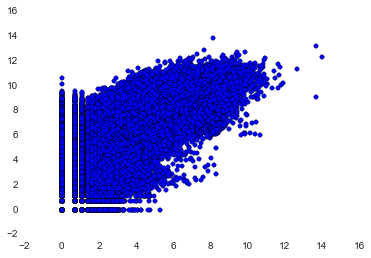

In [16]:
plt.scatter(np.log(iTunesData.iTunes_AlbumUnits_Net__d), np.log(iTunesData.iTunes_TrackUnits_Net__d))

PHEW! iTunes Album sales vs iTunes Track sales is a fairly linear relationship!

### Understanding Correlations
- I used the pearson method to create correlation matrices
- With the data from the correlation matrices, I coded them as follows:
    - X > 0.5 = Positive
    - -0.5 < X < 0.5 = No Correlation
    - X < -0.5 = Negative

In [22]:
def corr_coding(corr_mat):
    for col in corr_mat:
        i = 0
        while i < len(corr_mat[col]):
            if corr_mat[col][i] > 0.5:
                corr_mat[col][i] = 1
            elif -0.5 < corr_mat[col][i] < 0.5:
                corr_mat[col][i] = 0
            else:
                corr_mat[col][i] = -1
            i+=1
    return corr_mat

In [23]:
total_cols_gp_corr = data_clean[tot_cols_gp].corr(method='pearson')
delta_cols_corr = data_clean[delta_cols].corr(method ='pearson')

total_cols_gp_corr = corr_coding(total_cols_gp_corr)
delta_cols_corr = corr_coding(delta_cols_corr)

In [24]:
def countcorrs(corrmatrix):
    num_pos_corr = 0
    num_no_corr = 0
    num_neg_corr = 0
    for col in corrmatrix:
        num_pos_corr = num_pos_corr + corrmatrix[col].value_counts()[1]
        num_no_corr = num_no_corr + corrmatrix[col].value_counts()[0]
    num_neg_corr = corrmatrix.shape[0]*corrmatrix.shape[1] - num_pos_corr - num_no_corr
    return num_pos_corr, num_neg_corr, num_no_corr

In [25]:
delta_pos_corr, delta_neg_corr, delta_no_corr = countcorrs(delta_cols_corr)
total_pos_corr, total_neg_corr, total_no_corr = countcorrs(total_cols_gp_corr)
print "Percentage Positive Correlating Factors in Delta: ", float(delta_pos_corr)/(delta_pos_corr + delta_neg_corr + delta_no_corr)*100
print "Percentage Positive Correlating Factors in Total: ", float(total_pos_corr)/(total_pos_corr + total_neg_corr + total_no_corr)*100, '\n'
print "Percentage Negative Correlating Factors in Delta: ", float(delta_neg_corr)/(delta_pos_corr + delta_neg_corr + delta_no_corr)*100
print "Percentage Negative Correlating Factors in Total: ", float(total_neg_corr)/(total_pos_corr + total_neg_corr + total_no_corr)*100, '\n'
print "Percentage No Correlating Factors in Delta: ", float(delta_no_corr)/(delta_pos_corr + delta_neg_corr + delta_no_corr)*100
print "Percentage No Correlating Factors in Total: ", float(total_no_corr)/(total_pos_corr + total_neg_corr + total_no_corr)*100

Percentage Positive Correlating Factors in Delta:  7.37190082645
Percentage Positive Correlating Factors in Total:  3.83991346674 

Percentage Negative Correlating Factors in Delta:  0.0
Percentage Negative Correlating Factors in Total:  0.0 

Percentage No Correlating Factors in Delta:  92.6280991736
Percentage No Correlating Factors in Total:  96.1600865333


### This is great to note because it shows that there is very little linear dependancy between our variables...also, unexpected...

### Step 2b: Data Exploration - Graphically

<Container object of 12 artists>

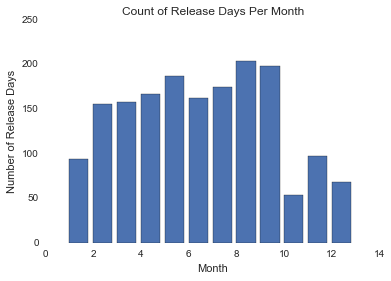

In [106]:
DF = data_clean[['IsReleaseDay', 'Month']].groupby('Month').aggregate(sum).sort('IsReleaseDay', ascending = False)
plt.title("Count of Release Days Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Release Days")
plt.bar(DF.index, DF.IsReleaseDay)

##This plot shows you how the tail end and beginning of the year do not have as many releases as the middle of the year. This has been a music industry trend for many years. I do not know why this occurs, but it always has. I've asked some people I know that work with album releases, and no one can pinpoint any reason. This is of course a very segmented group of people that I asked, who all work in the same genre, hip-hop! 

## A time series analysis would incorporate this type of factor into its predictive analysis

<Container object of 7 artists>

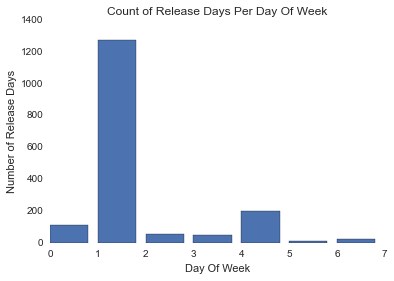

In [107]:
DF2 = data_clean[['IsReleaseDay', 'DayOfWeek']].groupby('DayOfWeek').aggregate(sum).sort('IsReleaseDay', ascending = False)
plt.title("Count of Release Days Per Day Of Week")
plt.xlabel("Day Of Week")
plt.ylabel("Number of Release Days")
plt.bar(DF2.index, DF2.IsReleaseDay)

## Tuesday has the most release days by FAR! One reason this is an "industry standard" is the way that Soundscan used to report album sales (Tuesday - Tuesday)

### Step 3: Data Modeling

### I decided to study the time series aspect of this data set later, for now, we just use the values

### Model Selection:

#### The scikit-Learn cheat sheet takes us to some possible Regression algorithms:
    - The suggestions here are just a few of the possibilities, but explicitly, the following are mentioned:
        - RidgeRegression SVR(kernel = 'linear') --> For many features being important
        - SVR(kernel = 'linear') EnsembleRegressors --> For many features being important and RidgeRegression not working
        - Lasso ElasticNet  --> For few features being important, I don't know anything about this model

###Input Variable Types:
####Categorical:
    - IsReleaseDay
    - DayOfWeek
    - Month
####Continuous:
    - All Else

In [8]:
y = data_clean['iTunes_TrackUnits_Net__d']

In [110]:
factor_cols = ['Month', 'DayOfWeek', 'IsReleaseDay', 'Facebook_PageLikes_d', 'Facebook_TalkingAboutThis_7day__d', 'Instagram_Comments_d', 
               'Instagram_Followers_d', 'Instagram_Friends_Following__d', 'Instagram_Likes_d', 'Instagram_Photos_d', 
               'Lastfm_Listeners_d', 'Lastfm_Plays_d', 'Lastfm_Shouts_d', 'MediabaseFeed_RadioSpins_d', 'MySpace_Friends_d', 
               'MySpace_Plays_d', 'MySpace_ProfileViews_d', 'Pandora_Fans_d', 'Purevolume_Comments_d', 
               'Purevolume_Fans_Favorites__d', 'Purevolume_Plays_d', 'RadioWave_InternetRadioImpressions_d', 
               'RadioWave_InternetRadioSpins_d', 'RadioWave_PandoraImpressions_d', 'RadioWave_PandoraSpins_d', 
               'RadioWave_RhapsodyImpressions_d', 'RadioWave_RhapsodySpins_d', 'RadioWave_SiriusImpressions_d', 
               'RadioWave_SiriusSpins_d', 'RadioWave_SlackerImpressions_d', 'RadioWave_SlackerSpins_d', 'Rdio_Collections_d', 
               'Rdio_Comments_d', 'Rdio_Playlists_d', 'Rdio_Plays_d', 'Rdio_TrackListeners_d', 'ReverbNation_Fans_d', 
               'ReverbNation_Plays_d', 'ReverbNation_RemoteImpressions_d', 'SoundCloud_Comments_d', 'SoundCloud_Downloads_d', 
               'SoundCloud_Followers_d', 'SoundCloud_Plays_d', 'Twitter_Followers_d', 'Twitter_Friends_Following__d', 
               'Twitter_Lists_d', 'Twitter_Tweets_d', 'Vevo_VideoViews_d', 'Vimeo_Comments_d', 'Vimeo_Plays_d', 
               'Vimeo_VideoLikes_d', 'Wikipedia_Pageviews_d', 'YouTube_ChannelViews_d', 'YouTube_Subscribers_d', 
               'YouTube_Thumbs_d', 'YouTube_VideoFavorites_d', 'YouTube_VideoRaters_d', 'YouTube_VideoViews_d']

In [111]:
(X_train, X_test, y_train, y_test) = train_test_split(data_clean[factor_cols], y, test_size = 0.3)

- X_train, X_test, y_train, and y_test are all for delta values

## Decision Tree Regressor (Thanks Ramesh!!)

In [112]:
tree_model = DecisionTreeRegressor(min_samples_leaf=10, max_depth=20)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=20,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=10, min_samples_split=2, random_state=None,
           splitter='best')

In [113]:
Decision_Tree_Predictions = tree_model.predict(X_test)

In [114]:
print "Decision Tree Accuracy: ", tree_model.score(X_test, y_test)

Decision Tree Accuracy:  0.794838472524


In [116]:
data_clean['Decision_Tree_Predicted_Vals'] = tree_model.predict(data_clean[factor_cols])

## Simple Linear Regression Models
- The Scikit-Learn suggested models

In [117]:
lin_model = LinearRegression().fit(X_train, y_train)

###Ridge model utilizes a model where the loss function is the linear least squares function (also known as Tikhonov Regularization) 


In [118]:
ridge_model = Ridge().fit(X_train, y_train)

###BayesianRidge estimates a probabilistic model of our regression problem. 
- Parameters are estimated by maximimizing the marginal log likelihood:
    - w  
    - alpha
    - lambda

In [119]:
bayes_model = BayesianRidge().fit(X_train, y_train)

###Step 4: Data Prediction and Algorithm Scoring

####Model Results

In [121]:
lin_scores = cross_val_score(lin_model, X_test, y_test, cv = 20)
ridge_scores = cross_val_score(ridge_model, X_test, y_test, cv = 20)
bayes_ridge_scores = cross_val_score(bayes_model, X_test, y_test, cv = 20)
decision_tree_scores = cross_val_score(tree_model, X_test, y_test, cv = 20)

In [122]:
print "Linear Regression Model Cross Val Score: ", lin_scores.mean()
print "Ridge Model Cross Val Score: ", ridge_scores.mean()
print "Bayes Ridge Model Cross Val Score: ", bayes_ridge_scores.mean()
print "Decision Tree Model Cross Val Score: ", decision_tree_scores.mean()

Linear Regression Model Cross Val Score:  0.55254928798
Ridge Model Cross Val Score:  0.552548076554
Bayes Ridge Model Cross Val Score:  0.552335881316
Decision Tree Model Cross Val Score:  0.762917653951


### All of the linear model scores of models are pretty much identical ?!? Decision Tree Model is much better than all of the traditional linear models!! (Thanks Ramesh!!) 

In [123]:
PredictionDF = pd.DataFrame(data_clean['ArtistId'])
PredictionDF['iTunes_Sales'] = data_clean['iTunes_TrackUnits_Net__d']

In [124]:
lin_prediction = lin_model.predict(data_clean[factor_cols])
ridge_prediction = ridge_model.predict(data_clean[factor_cols])
bayes_ridge_prediction = bayes_model.predict(data_clean[factor_cols])
decision_tree_prediction = tree_model.predict(data_clean[factor_cols])

In [125]:
PredictionDF['Linear_Model_Predictions'] = lin_prediction
PredictionDF['Ridge_Model_Predictions'] = ridge_prediction
PredictionDF['Bayes_Ridge_Predictions'] = bayes_ridge_prediction
PredictionDF['Decision_Tree_Predictions'] = decision_tree_prediction

In [126]:
total_by_artist = PredictionDF.groupby('ArtistId').aggregate(sum)
total_by_artist['Decision_Tree_%_Accuracy'] = 1 - np.abs((total_by_artist.Decision_Tree_Predictions - total_by_artist.iTunes_Sales)/total_by_artist.iTunes_Sales)
total_by_artist['Linear_Model_%_Accuracy'] = 1 - np.abs((total_by_artist.Linear_Model_Predictions - total_by_artist.iTunes_Sales)/total_by_artist.iTunes_Sales)
total_by_artist['Ridge_Model_%_Accuracy'] = 1 - np.abs((total_by_artist.Ridge_Model_Predictions - total_by_artist.iTunes_Sales)/total_by_artist.iTunes_Sales)
total_by_artist['Bayes_Model_%_Accuracy'] = 1 - np.abs((total_by_artist.Bayes_Ridge_Predictions - total_by_artist.iTunes_Sales)/total_by_artist.iTunes_Sales)

# This table is not an actual accuracy table, it is only a table that sums up all of the iTunes sales for an artist and scores the total number for the time range given. It is simply a litmus test that does not have any quantitative significance

In [127]:
total_by_artist.sort('iTunes_Sales', ascending = False)[['iTunes_Sales', 'Decision_Tree_%_Accuracy', 'Linear_Model_%_Accuracy', 'Ridge_Model_%_Accuracy', 'Bayes_Model_%_Accuracy']] 

,iTunes_Sales,Decision_Tree_%_Accuracy,Linear_Model_%_Accuracy,Ridge_Model_%_Accuracy,Bayes_Model_%_Accuracy
ArtistId,,,,,
589283,25980646,0.988615,0.189324,0.189325,0.189388
4263,25742243,0.990607,0.973137,0.973137,0.973108
30617,21816835,0.964643,0.928546,0.928546,0.928531
1939,21026956,0.938551,0.551670,0.551669,0.551585
26345,19234052,0.969131,0.896180,0.896179,0.896011
20251,18548008,0.975124,0.811176,0.811176,0.811182
10483,18425029,0.984433,0.752205,0.752205,0.752162
1359,16912772,0.992343,0.949612,0.949612,0.949635
572881,16522949,0.990399,0.877585,0.877586,0.877615


# Actual vs Linear Model Predictions (they all look the same!)

(0, 200000)

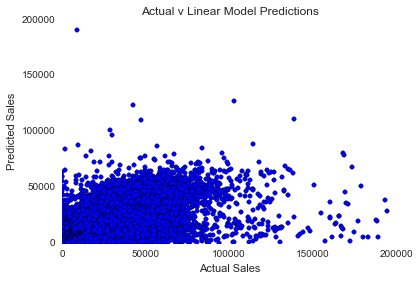

In [128]:
fig, ax = plt.subplots(1,1)
ax.scatter(PredictionDF['iTunes_Sales'], PredictionDF['Linear_Model_Predictions'])
plt.title("Actual v Linear Model Predictions")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
ax.set_xlim(0, 200000)
ax.set_ylim(0, 200000)

- Not really a clear relationship...

# Actual vs Decision Tree Predictions

(0, 200000)

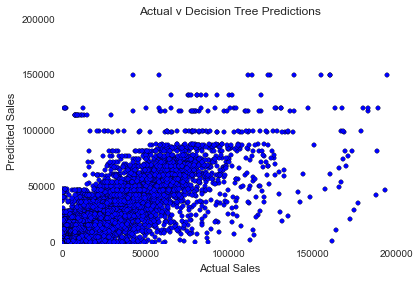

In [129]:
fig, ax = plt.subplots(1,1)
ax.scatter(PredictionDF['iTunes_Sales'], PredictionDF['Decision_Tree_Predictions'])
plt.title("Actual v Decision Tree Predictions")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
ax.set_xlim(0, 200000)
ax.set_ylim(0, 200000)

- The relationship looks pretty linear! 

(0, 200000)

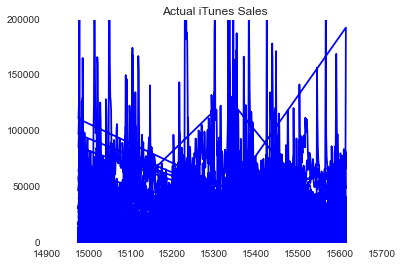

In [148]:
plt.plot(data_clean['Day'], data_clean['iTunes_TrackUnits_Net__d'], color = 'blue')
plt.title("Actual iTunes Sales")
plt.ylim(0, 200000)

(0, 200000)

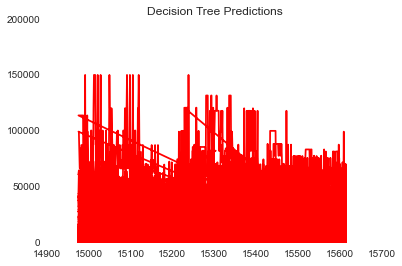

In [147]:
plt.plot(data_clean['Day'], data_clean['Decision_Tree_Predicted_Vals'], color = 'red')
plt.title("Decision Tree Predictions")
plt.ylim(0, 200000)

### Actual and Predicted values look pretty close!

#So What's it all mean?

### The linear models using the entire dataset regardless of artist perform well on most artists with high volumes of iTunes sales, but poorly on artists with low volumes of iTunes sales

- I found it interesting/weird that all of the linear model approaches gave pretty much the exact same results, Maybe Alessandro can help us understand why?
- I think a linear model approach would be better served on "similar" artists
    - Similar in a sense that their media metrics are on the same level
    - Split the artists into clusters and analyze each cluster separately?
- I was unable to incorporate the "GP" (Growth Percentage) data that I feel would play a larger role in analyzing this data
    - When running the model on these "normalized" variables, I was unable to get any results from my linear models
    - A few of the data points that came from the GP variables did not look right, and I did not have the time to find out why
        - They could be from release days or other significant events (in other words they could be correctly reported)
        - They could simply be an error when pulling that days data from API's (in other words they could be incorrectly reported)
- A closer examination of multicollinearities is needed as well

###The Decision Tree model worked much much better than the linear regression models

# Scored at ~75% compared to ~59% accuracy

#What could be done differently/better?

### One possibility here is that the data has not been preprocessed in the best way possible

- I didn't use cloud computing because the fear of the cash God was placed in my gmail account when a bill for a few hundred bucks from Amazon AWS arrived for a non-destroyed cluster than I ran overnight
    - They reversed it
    - I need to understand things better before I play games! =)
- With more computing power, this analysis can be a lot better, and way easier to perform
- Entering in missing data makes me nervous
    - We are making generalized statements to add missing data to a data set
    - Obviously the best bet statistically would be to throw missing data rows out
    - This would cost us money, essentially disregarding samples
- A better understanding of the input variables are necessary
    - i.e. I cannot answer the question for why there would be so many negative iTunes sales, I've never experienced that in real life
- I want to study the instances for when this model performed poorly to see if I can find a trend in what caused the poor performance

### Another possibility is that there are missing factors that are not being recorded by this data set

- This dataset analyzes a specific set of online media only, nothing offline like club performances, concerts, festivals, DJ spins, brand affiliation, artist/group affiliation, etc
- Online media changes a lot, sometimes it feels like there is a new source of data collection every hour
- Since all of the downloading, and the music industry was turned upside down, it seems that the major sources of music consumption have stabilized:
    - Spotify, Pandora, iTunes, Soundcloud, Youtube, Beats, and a few others
- This data set captures one type of significant event: Is today a release day or not? 
    - There could potentially be many other significant events that contribute to an artists sales
        - Tour dates
        - Firesales? 
- Sentiment
    - This data does not take into mind positive feelings towards the music or negative feelings towards the music
    - Possibly found through analyzing Tweets? YouTube comments?
        - Much of the internet is negative from the start........just take a look at the top comment of almost any really popular YouTube video

## Next Steps:
- The idea here is to provide a tool for A&R representatives to find artists that are worth listening to right now:
    - The internet has changed how artists are discovered, and dilluted the path that artists take to get their music to A&R reps
    - A baseline filter is needed....
    
- I would like to explore this data more, understand the input variables better so I can get a feel for what to do with missing data for each column

- I would like to apply this algorithm less generally so that it is more artist specific and can help guide artists in their growth campagins individually...each artist is pretty much it's own business!

- I would like to explore this data in a few separate ways:
    - Genre Specific
    - Independent or Signed Artists
    - Large, Medium, or Small online presence

- I would like to use this data to explain how artists should market themselves within a genre by genre basis (using the Beta's from the regression models)

- The ultimate goal here is to be able to eventually predict which artist is on his/her way to becoming the next phenom. This data set and analysis would only be a starting point
    - I always imagine myself with a pair of headphones in a room with a thousand screens all around me, kicking back, listening to music, reading a comic book
    - Then, a faint 'ding! ding! ding!' starts, with a small red flashing light on one of the thousands of screens, as I fall out of my chair, get up and walk over, tip my glasses down, and say "Well, I'll be damned, it looks like we found the next big sound!"

### Nothing can take away from the power of the human element in identifying music that is great

- The use of data has been scrutinized in the music industry.
- My belief is that it is scrutinized because the true use is not understood by an industry governed by rules that were made decades ago by executives who no longer see the real world
- This is change and will change even more
- The use of data still is no replacement for human intuition in talent identification. 
- I always see these types of tools to provide the initial focus. The success or demise of an artist has much more to do with just social media metrics.
    - Attempting to quantify things like "hunger", "flexibility", "groundbreaking" has been futile to me.
    - These are all things that need human intuition to truly identify.
    - In this day and age of massive music saturation, a filter is needed, and I think a deep analysis of data is the answer

# LASTLY
### Explore the time series nature of this data.
- Time series would be powerful because I could essentially predict an artists iTunes sales with a certain degree of confidence
- When thinking about this, it actully becomes a question of predicting all of their social media numbers as well, which is an interesting data science question in itself! 

# Clustering to determine the artists that have similar features to create groups of artists to study

### This slice is the mean values for every metric, for every artist

In [80]:
meanmap_clean = data_clean.groupby('ArtistId').mean()
meanmap_clean.fillna(0, inplace = True)

### This will separate the artists into 4 separate groups

In [81]:
clf = KMeans(n_clusters=8).fit(meanmap_clean[factor_cols]) # 10 Clusters
predictions = clf.predict(meanmap_clean[factor_cols]) 
meanmap_clean['Artist_Cluster'] = predictions

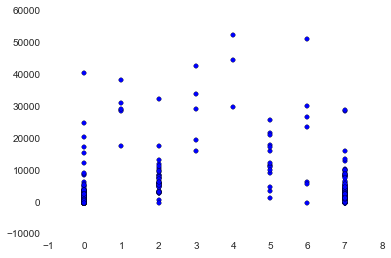

In [82]:
plt.scatter(meanmap_clean['Artist_Cluster'], meanmap_clean['iTunes_TrackUnits_Net__d'])

# I thought the large differences in iTunes sales would be a huge factor in determining these groups, but apparantly not so much!

In [83]:
meanmap_clean['Artist_Cluster'].value_counts()

0    1356
7     127
2      43
5      15
6       7
1       6
3       5
4       3
dtype: int64

# One cluster has 1356 of the artists in it...which is 87% of the artists..........

In [103]:
#for artist in data_clean['ArtistId']:
#    data_clean[data_clean['ArtistId'] == artist]['Artist_Cluster'] = meanmap_clean[meanmap_clean.index == artist]['Artist_Cluster']